# Привет уважаемый соискатель!
 Тебе предстоит пройти пару простых заданий по глубокому обучению. Это нормально не всегда понимать сразу как
 сделать ту или иную часть, ведь у тебя есть возможность разобраться во всём самому! А этот навык куда ценнее
 знаний.
 Отметим сразу, что весь код написанный нами, есть лишь один из возможных путей решения задачи и ты не обязан ему
 следовать. Возможно, ты решишь использовать другие, более удобные, решения. Но как и в случае использования
 наших подсказок, так и без них, мы рекомендуем понимать, что ты пишешь и зачем. Мы будем спрашивать на собесе!
 Но ты не пугайся) Лучше разберись что и как.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from torch.utils.data import DataLoader
import os
from torch.utils.data import IterableDataset
from torchinfo import summary
from tqdm.auto import tqdm


from typing import List, Tuple, Dict

# Задания и оценивание
В тестировании присутствует 3 части:
- Составление датаеста
- Конструкция архитектуры нейросети
- Обучение и аналитика

Каждая из них представляет собой важный этап работы Ml-щика нашей команды, поэтому постарайся сделать их все.
Все они приносят равное количество баллов. В каждой части есть задание со звёздочкой, его делать не обязательно -
 но если ты всё-таки его сделаешь, то это поможет нам оценить твои компетенции.


Скажем пару слов о данных. Признаки представляют из себя из себя 11 непрерывных переменных, таргет - целочисленную оценку от 1 до 10. Подумай, что это за тип задачи.

Раз таргет целое число, то задача - классфикиция с 10 лейблами.

In [56]:
# будем придерживаться стандартов и писать device-agnostic код

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

# Составление датаеста

- Загрузи данные из файла our data. (тут тебе может помочь библиотека pandas)
- Раздели их по переменным X и Y.
- Сконструируй класс MyDataset. (про такого функионал класса можешь почитать [тут](https:pytorch.org/tutorials/beginner/basics/data_tutorial.html))

- "*" Импортируй линейную регрессию из библиотеки sklearn и обучи её на тех же данных. Ура! теперь у нас есть безлайн!


Загрузите данные и разделите на X, Y

In [58]:
data = pd.read_csv('my_data.csv', sep = ';', header = 1) # что-то связанное с csv файлом
X = data.drop('target', axis = 1) # что-то связанное с data
Y = data['target'] # что-то связанное с data

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Создайте класс DataSet - https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [60]:
class MyDataset(Dataset):
    def __init__(self, x: pd.DataFrame, y: List[int]):
        self.x = torch.from_numpy(x.to_numpy()).type(torch.float)
        self.y = torch.from_numpy(np.array(y.values)).type(torch.long)

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Returns a sample from the dataset at the given index idx.
        :param idx: Index of the sample to return.
        :return: Sample
        """
        if 0 <= idx < len(self.x):
            return self.x[idx], self.y[idx]
        else:
            raise IndexError("Wrong index!")


In [61]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [62]:
#  модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Оценка
score = model.score(X_test, y_test)
print(f'R-squared score: {score}')

R-squared score: 0.40318034127962277


# Сконструируйте класс нейронной сети
В этом задании тебе предстоит сконструировать полносвязную двухслойную нейронную сеть.

- Вспомните какие сущности необходимы для обучения нейронной сети и включите их в атрибуты класса.
- Основываясь на типе данной задачи выберете подходящую лосс функцию.
- На основе требований первых двух пунктов заполните методы forward и training_step
- "*" Настрой обучение батчами (это не обязательно делать в противном случае)

Напоминаем, что не обязательно пользоваться предлагаемым шаблоном! Если вы знаете более быстрые и простые пути,
то будет интересно на них посмотреть.

In [63]:
class MyNet(nn.Module):
    def __init__(self,
                 input_features: int,
                 output_features: int,
                 hidden_units: int = 22
                 ): #тут должны дополнительно передаваться какие-то параметры
        super().__init__()

        # тут должно быть что-то про устройство сети
        self.layers = nn.Sequential(nn.Linear(input_features, hidden_units),
                                    nn.ReLU(),
                                    nn.Linear(hidden_units, output_features),
                                    nn.ReLU(),
                                    )

    def forward(self, x: torch.Tensor):
        """
        Прямой проход по всем слоям сети для получения предсказания.
        :param x:
        Входящие данные.
        :return:
        Предсказанные значения для входящих данных.
        """

        return self.layers(x)

In [64]:
!pip -q install torchmetrics

In [65]:
from torchmetrics import Accuracy


accuracy_fn = Accuracy(task="multiclass", num_classes=10).to(device)

In [66]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [67]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# Обучение и аналитика
В этом задании тебе предстоит обучить сконструированную архитектуру.

- Создай объект класса MyDataset и MyNet, а также других атрибутов, если ваше решение их предусматривает.
- Напишите цикл обучения нейронной сети.
- Обучите нейронную сеть и оцените финальной качество на валидационном датасете.
- "*" Каждый N-ый шаг изображайте на графике, как менялось значение лосс функции на тестовых данных и
на части валидационных данных.

In [68]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
model = MyNet(11, 10).to(device)

BATCH_SIZE = 16
NUM_EPOCHS = 1500

In [69]:
print(model)

MyNet(
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=22, bias=True)
    (1): ReLU()
    (2): Linear(in_features=22, out_features=10, bias=True)
    (3): ReLU()
  )
)


In [70]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

In [71]:
summary(model, input_size=[BATCH_SIZE, 11])

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    [16, 10]                  --
├─Sequential: 1-1                        [16, 10]                  --
│    └─Linear: 2-1                       [16, 22]                  264
│    └─ReLU: 2-2                         [16, 22]                  --
│    └─Linear: 2-3                       [16, 10]                  230
│    └─ReLU: 2-4                         [16, 10]                  --
Total params: 494
Trainable params: 494
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [72]:
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=0)

test_dataloader = DataLoader(test_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=0)

In [73]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        if epoch % 100 == 0:
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
            )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [74]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6620 | train_acc: 0.4707 | test_loss: 1.3856 | test_acc: 0.4781
Epoch: 101 | train_loss: 1.0292 | train_acc: 0.5912 | test_loss: 1.0654 | test_acc: 0.5656
Epoch: 201 | train_loss: 1.0087 | train_acc: 0.6067 | test_loss: 1.0429 | test_acc: 0.5719
Epoch: 301 | train_loss: 0.9841 | train_acc: 0.6285 | test_loss: 1.0393 | test_acc: 0.6031
Epoch: 401 | train_loss: 0.9862 | train_acc: 0.6270 | test_loss: 1.0661 | test_acc: 0.5969
Epoch: 501 | train_loss: 0.9675 | train_acc: 0.6184 | test_loss: 1.0884 | test_acc: 0.5906
Epoch: 601 | train_loss: 0.9591 | train_acc: 0.6426 | test_loss: 1.0830 | test_acc: 0.5875
Epoch: 701 | train_loss: 0.9573 | train_acc: 0.6341 | test_loss: 1.0605 | test_acc: 0.6062
Epoch: 801 | train_loss: 0.9535 | train_acc: 0.6366 | test_loss: 1.0735 | test_acc: 0.5938
Epoch: 901 | train_loss: 0.9504 | train_acc: 0.6333 | test_loss: 1.0975 | test_acc: 0.5750
Epoch: 1001 | train_loss: 0.9455 | train_acc: 0.6403 | test_loss: 1.0830 | test_acc: 0.6062


In [75]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

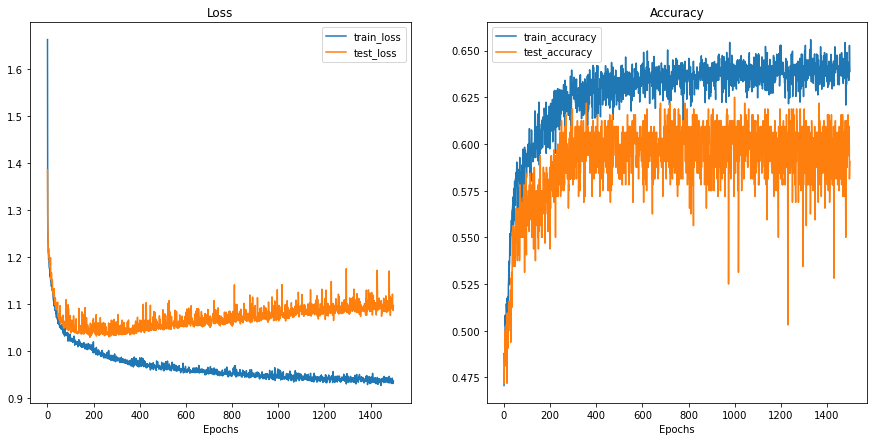

In [76]:
plot_loss_curves(model_results)